# Use cases

In this notebook, we describe different use cases for
 applying stochastic service composition.


In [1]:
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from examples.notebooks.utils import render_service, render_target, render_composition_mdp, print_policy_data, print_value_function, print_q_value_function
from stochastic_service_composition.composition import composition_mdp
from stochastic_service_composition.services import build_service_from_transitions
from stochastic_service_composition.target import build_target_from_transitions


## Simple service composition: Website

This simple example, showed in

[De Giacomo, G., Mecella, M., & Patrizi, F. (2014).
Automated service composition based on behaviors: The roman model.
In Web services foundations (pp. 189-214). Springer, New York, NY.](http://www.diag.uniroma1.it/degiacom/papers/2014/WSF14.pdf)

consists of a simple website in which the user wants
to login, choose the country, stock, and logout (c).
We then have the login service (a) and the form
service (b). The orchestrator (d) has to assign
the action to the right service. This case is
quite trivial as there is no competition
among services since they always support different actions.
The reward, in our case, is given whenever the user is able
to complete the entire sequence of actions, right after the logout

[![click here if the image does not display](images/simple-service-composition.png)](images/simple-service-composition.png)

Let us define the service community:

In [2]:
login_service = build_service_from_transitions(
    {
        "s0": {"login": "s1"},
        "s1": {"logout": "s0"}
    },
    "s0",
    {"s0"}
)

form_service = build_service_from_transitions(
    {
        "s0": {"country": "s1"},
        "s1": {"currency": "s0", "stock": "s0"}
    },
    "s0",
    {"s0"}
)

The login service:

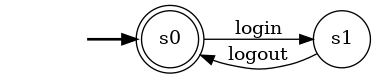

In [3]:
render_service(login_service)

The form service:

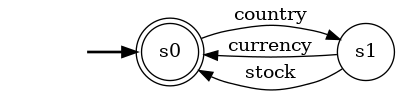

In [4]:
render_service(form_service)

Now we define the target service:

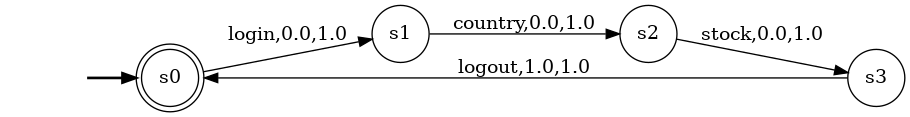

In [5]:
target = build_target_from_transitions(
    {
        "s0": {"login": ("s1", 1.0, 0.0)},
        "s1": {"country": ("s2", 1.0, 0.0)},
        "s2": {"stock": ("s3", 1.0, 0.0)},
        "s3": {"logout": ("s0", 1.0, 1.0)},
    },
    "s0",
    {"s0"}
)
render_target(target)

The product MDP is:

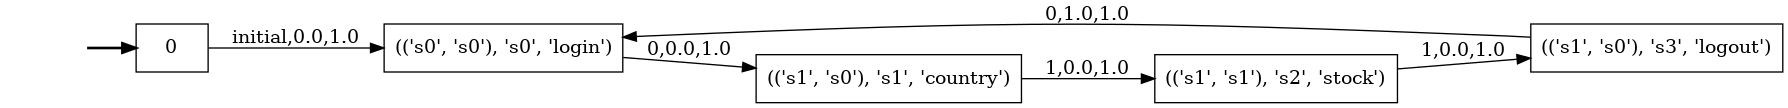

In [6]:
mdp = composition_mdp(target, login_service, form_service)
render_composition_mdp(mdp)

The optimal policy is the only one allowed

In [7]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
q_value_function.pop(0, None)

print_policy_data(opt_policy)
print()
print_value_function(value_function)
print()
print_q_value_function(q_value_function)


Policy:
State=(('s0', 's0'), 's0', 'login'),	Action=0
State=(('s1', 's0'), 's1', 'country'),	Action=1
State=(('s1', 's0'), 's3', 'logout'),	Action=0
State=(('s1', 's1'), 's2', 'stock'),	Action=1

Value function:
State=(('s0', 's0'), 's0', 'login'),	value=2.119802268101193
State=(('s1', 's0'), 's1', 'country'),	value=2.35533585344577
State=(('s1', 's0'), 's3', 'logout'),	value=2.907822041291074
State=(('s1', 's1'), 's2', 'stock'),	value=2.6170398371619665

Q-value function:
State=(('s0', 's0'), 's0', 'login'):
	Action=0,	Value=2.1198022681011928

State=(('s1', 's0'), 's1', 'country'):
	Action=1,	Value=2.35533585344577

State=(('s1', 's0'), 's3', 'logout'):
	Action=0,	Value=2.907822041291074

State=(('s1', 's1'), 's2', 'stock'):
	Action=1,	Value=2.6170398371619665



That is, as expected, `login` and `logout` are assigned
 to service `0` and `country` and `stock` to service `1`.

## A variant of the website service

Here we consider a variant in which the services can
erroneously report that they can provide a service,
but that leads to a dead-end.
An exact solution is still possible,
and the solution of the composition MDP
will lead to the right orchestration.

Let's define the same services, but with additional
actions:

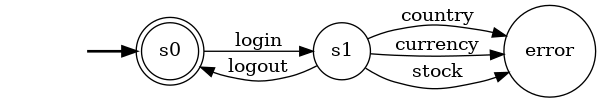

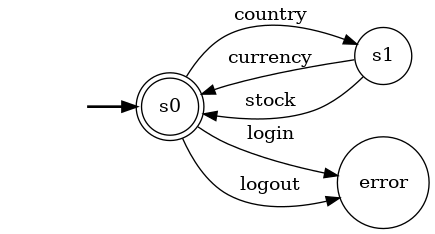

In [8]:
login_service = build_service_from_transitions(
    {
        "s0": {
            "login": "s1"
        },
        "s1": {
            "logout": "s0",
            "country": "error",
            "currency": "error",
            "stock": "error"
        },
        "error": {}
    },
    "s0",
    {"s0"}
)

form_service = build_service_from_transitions(
    {
        "s0": {"login": "error", "logout": "error", "country": "s1"},
        "s1": {"currency": "s0", "stock": "s0"},
        "error": {}
    },
    "s0",
    {"s0"}
)

render_service(login_service)
render_service(form_service)

This time, the composition MDP is:

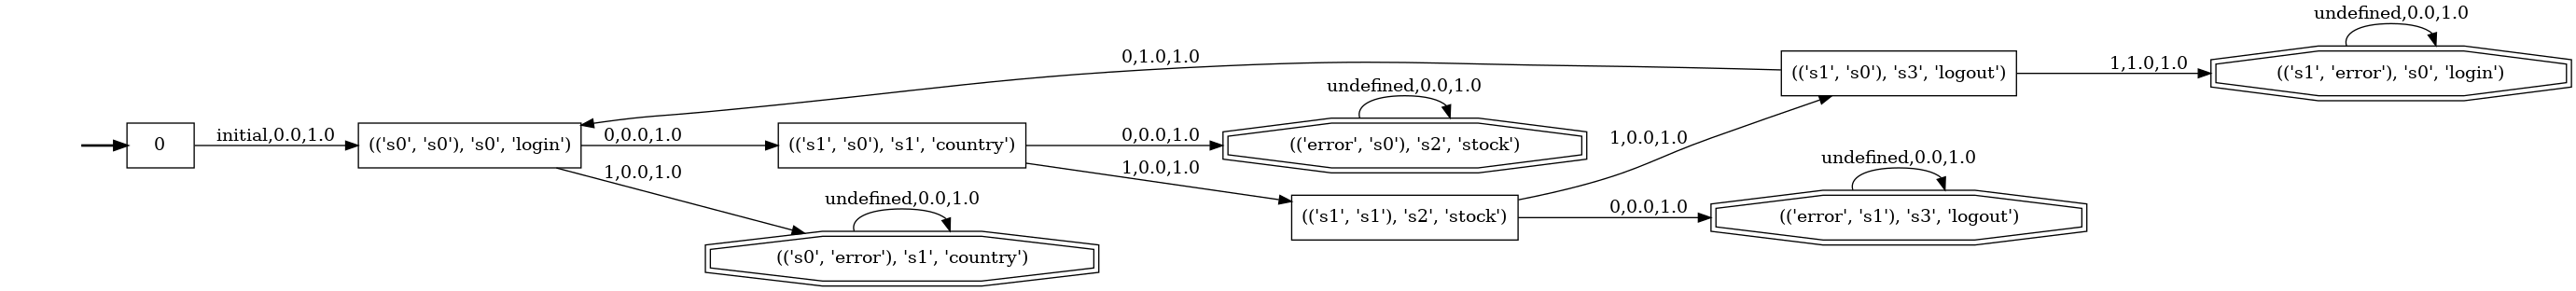

In [9]:
mdp = composition_mdp(target, login_service, form_service)
render_composition_mdp(mdp)

The optimal policy correctly avoids dead ends:

In [10]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
q_value_function.pop(0, None)

print_policy_data(opt_policy)
print()
print_value_function(value_function)
print()
print_q_value_function(q_value_function)

Policy:
State=(('error', 's0'), 's2', 'stock'),	Action=undefined
State=(('error', 's1'), 's3', 'logout'),	Action=undefined
State=(('s0', 'error'), 's1', 'country'),	Action=undefined
State=(('s0', 's0'), 's0', 'login'),	Action=0
State=(('s1', 'error'), 's0', 'login'),	Action=undefined
State=(('s1', 's0'), 's1', 'country'),	Action=1
State=(('s1', 's0'), 's3', 'logout'),	Action=0
State=(('s1', 's1'), 's2', 'stock'),	Action=1

Value function:
State=(('error', 's0'), 's2', 'stock'),	value=0.0
State=(('error', 's1'), 's3', 'logout'),	value=0.0
State=(('s0', 'error'), 's1', 'country'),	value=0.0
State=(('s0', 's0'), 's0', 'login'),	value=2.119802268101193
State=(('s1', 'error'), 's0', 'login'),	value=0.0
State=(('s1', 's0'), 's1', 'country'),	value=2.35533585344577
State=(('s1', 's0'), 's3', 'logout'),	value=2.907822041291074
State=(('s1', 's1'), 's2', 'stock'),	value=2.6170398371619665

Q-value function:
State=(('error', 's0'), 's2', 'stock'):
	Action=undefined,	Value=0.0

State=(('error', '

## The Garden Bots System

Here we consider a variant of the example described in:

[Yadav, N., & Sardina, S. (2011, May).
Decision theoretic behavior composition.
In The 10th International Conference on Autonomous Agents and Multiagent Systems
-Volume 2 (pp. 575-582).](https://www.researchgate.net/publication/221456691_Decision_theoretic_behavior_composition)

[![click here if the image does not display](images/garden-bots-system.png)](images/garden-bots-system.png)

---
> :warning: **NOTE: in the following, for simplicity, we don't consider**
> - ***the environment*** and
> - **the *stochasticity of the services*.**
---

In the gardening scenario,  we assume there are three available garden bots:

- The cleaner bot **BCleaner** cleans the garden by collecting the fallen leaves, dirt, waste, etc., into its own bucket. Its bucket gets filled up with a cleaning session, and the bot has to empty it to be able to start cleaning again. We assume the empty action involves emptying all garden bins as well as the bots' buckets. 
- The plucker bot **BPlucker** can pluck and clean the garden; since it is not equipped with a bucket, it plucks and collects from the ground directly.  
- the multi-bot **BMulti** has the capability to water the plants and pluck. It has a small bucket, and so it needs to empty it after every plucking session.

The  desired  behavior  required  to  maintain  thegarden in a particular season is not directly represented by any ofthe existing bots in the garden, and is modeled by the deterministic uniform-reward target bot **TGarden** shown in Figure 1. Intuitively, the garden should always be cleaned first to remove any fallen leaves and dirt, followed by either plucking or watering the garden. Since flowers and fruits do not grow everyday, the plucking is required only 30% of the time; 70% of the time a request for watering the garden will be issued.  Finally, the bins are to be emptied, and the whole process can repeat again.  All requests are of equal value, namely, 1 unit (second component in each transition label).


BCleaner


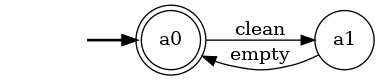

In [11]:
print("BCleaner")
bcleaner_service = build_service_from_transitions(
    {
        "a0": {"clean": "a1"},
        "a1": {"empty": "a0"}
    },
    "a0",
    {"a0"}
)
render_service(bcleaner_service)


BMulti


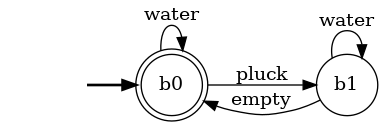

In [12]:
print("BMulti")
bmulti_service = build_service_from_transitions(
    {
        "b0": {"water": "b0", "pluck": "b1"},
        "b1": {"water": "b1", "empty": "b0"}
    },
    "b0",
    {"b0"}
)
render_service(bmulti_service)


BPlucker


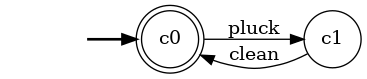

In [13]:
print("BPlucker")
bplucker_service = build_service_from_transitions(
    {
        "c0": {"pluck": "c1"},
        "c1": {"clean": "c0"}
    },
    "c0",
    {"c0"}
)
render_service(bplucker_service)

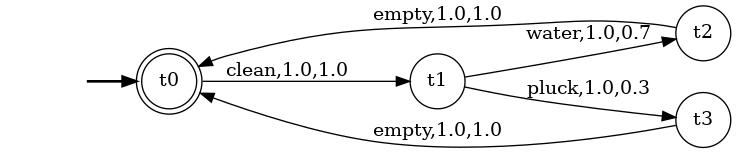

In [14]:
target = build_target_from_transitions(
    {
        "t0": {"clean": ("t1", 1.0, 1.0)},
        "t1": {"water": ("t2", 0.7, 1.0), "pluck": ("t3", 0.3, 1.0)},
        "t2": {"empty": ("t0", 1.0, 1.0)},
        "t3": {"empty": ("t0", 1.0, 1.0)},
    },
    "t0",
    {"t0"}
)
render_target(target)

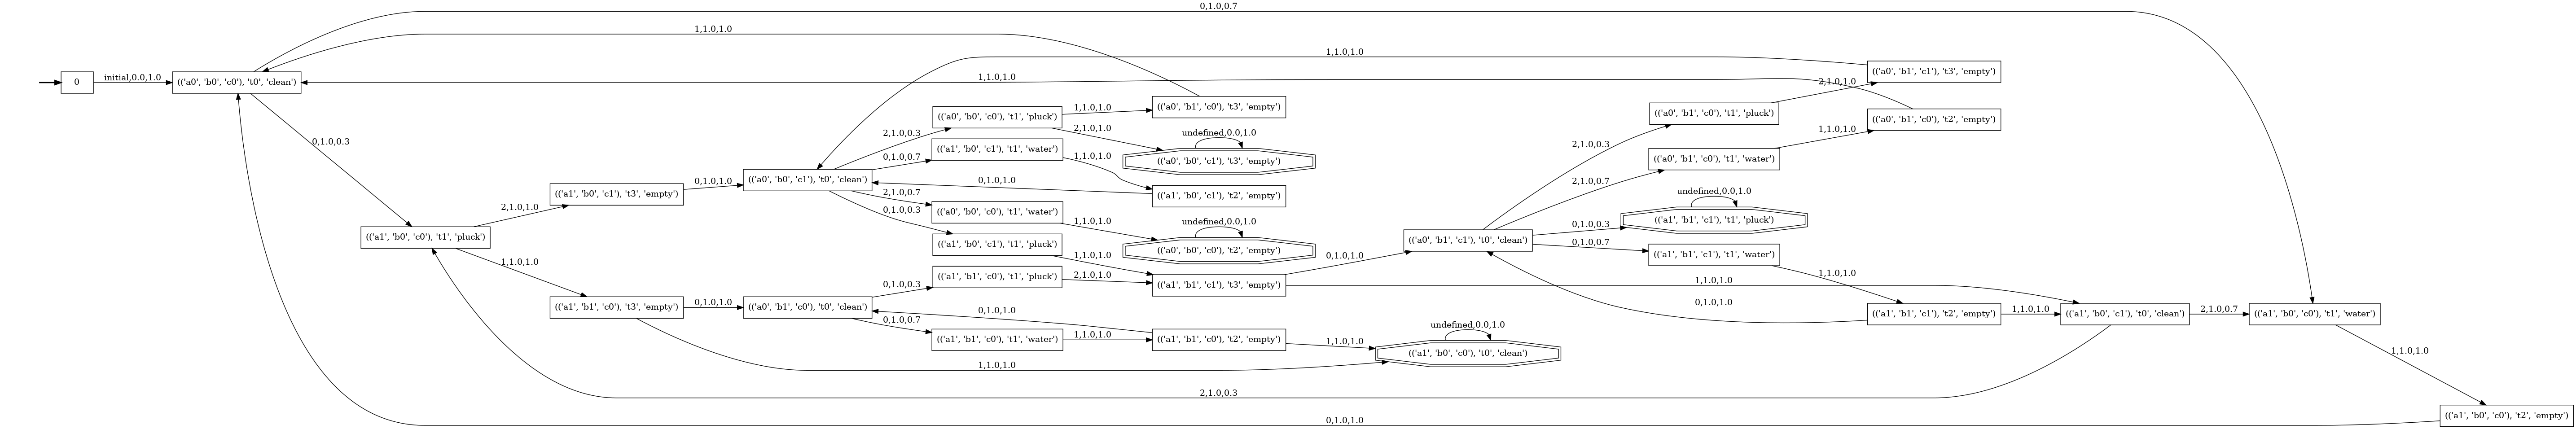

In [15]:
mdp = composition_mdp(target, bcleaner_service, bmulti_service, bplucker_service, gamma=0.9)
render_composition_mdp(mdp)

In [16]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)


In [17]:
print_policy_data(opt_policy)


Policy:
State=(('a0', 'b0', 'c0'), 't0', 'clean'),	Action=0
State=(('a0', 'b0', 'c0'), 't1', 'pluck'),	Action=1
State=(('a0', 'b0', 'c0'), 't1', 'water'),	Action=1
State=(('a0', 'b0', 'c0'), 't2', 'empty'),	Action=undefined
State=(('a0', 'b0', 'c1'), 't0', 'clean'),	Action=0
State=(('a0', 'b0', 'c1'), 't3', 'empty'),	Action=undefined
State=(('a0', 'b1', 'c0'), 't0', 'clean'),	Action=0
State=(('a0', 'b1', 'c0'), 't1', 'pluck'),	Action=2
State=(('a0', 'b1', 'c0'), 't1', 'water'),	Action=1
State=(('a0', 'b1', 'c0'), 't2', 'empty'),	Action=1
State=(('a0', 'b1', 'c0'), 't3', 'empty'),	Action=1
State=(('a0', 'b1', 'c1'), 't0', 'clean'),	Action=2
State=(('a0', 'b1', 'c1'), 't3', 'empty'),	Action=1
State=(('a1', 'b0', 'c0'), 't0', 'clean'),	Action=undefined
State=(('a1', 'b0', 'c0'), 't1', 'pluck'),	Action=1
State=(('a1', 'b0', 'c0'), 't1', 'water'),	Action=1
State=(('a1', 'b0', 'c0'), 't2', 'empty'),	Action=0
State=(('a1', 'b0', 'c1'), 't0', 'clean'),	Action=2
State=(('a1', 'b0', 'c1'), 't1',

In [18]:
print_value_function(value_function)


Value function:
State=(('a0', 'b0', 'c0'), 't0', 'clean'),	value=10.000000000000005
State=(('a0', 'b0', 'c0'), 't1', 'pluck'),	value=10.000000000000004
State=(('a0', 'b0', 'c0'), 't1', 'water'),	value=1.0
State=(('a0', 'b0', 'c0'), 't2', 'empty'),	value=0.0
State=(('a0', 'b0', 'c1'), 't0', 'clean'),	value=10.000000000000004
State=(('a0', 'b0', 'c1'), 't3', 'empty'),	value=0.0
State=(('a0', 'b1', 'c0'), 't0', 'clean'),	value=10.000000000000005
State=(('a0', 'b1', 'c0'), 't1', 'pluck'),	value=10.000000000000005
State=(('a0', 'b1', 'c0'), 't1', 'water'),	value=10.000000000000004
State=(('a0', 'b1', 'c0'), 't2', 'empty'),	value=10.000000000000005
State=(('a0', 'b1', 'c0'), 't3', 'empty'),	value=10.000000000000004
State=(('a0', 'b1', 'c1'), 't0', 'clean'),	value=10.000000000000007
State=(('a0', 'b1', 'c1'), 't3', 'empty'),	value=10.000000000000004
State=(('a1', 'b0', 'c0'), 't0', 'clean'),	value=0.0
State=(('a1', 'b0', 'c0'), 't1', 'pluck'),	value=10.000000000000004
State=(('a1', 'b0', 'c0'

In [19]:
print_q_value_function(q_value_function)

Q-value function:
State=(('a0', 'b0', 'c0'), 't0', 'clean'):
	Action=0,	Value=10.000000000000004

State=(('a0', 'b0', 'c0'), 't1', 'pluck'):
	Action=1,	Value=10.000000000000004
	Action=2,	Value=1.0

State=(('a0', 'b0', 'c0'), 't1', 'water'):
	Action=1,	Value=1.0

State=(('a0', 'b0', 'c0'), 't2', 'empty'):
	Action=undefined,	Value=0.0

State=(('a0', 'b0', 'c1'), 't0', 'clean'):
	Action=0,	Value=10.000000000000004
	Action=2,	Value=4.330000000000001

State=(('a0', 'b0', 'c1'), 't3', 'empty'):
	Action=undefined,	Value=0.0

State=(('a0', 'b1', 'c0'), 't0', 'clean'):
	Action=0,	Value=10.000000000000004

State=(('a0', 'b1', 'c0'), 't1', 'pluck'):
	Action=2,	Value=10.000000000000004

State=(('a0', 'b1', 'c0'), 't1', 'water'):
	Action=1,	Value=10.000000000000005

State=(('a0', 'b1', 'c0'), 't2', 'empty'):
	Action=1,	Value=10.000000000000005

State=(('a0', 'b1', 'c0'), 't3', 'empty'):
	Action=1,	Value=10.000000000000005

State=(('a0', 'b1', 'c1'), 't0', 'clean'):
	Action=0,	Value=7.3000000000000

## Human-Robot Collaboration (HRC) use case

 We use the case study described in:

[Tsarouchi, P., Makris, S., & Chryssolouris, G. (2016).
On a human and dual-arm robot task planning method.
Procedia CIRP, 57, 551-555.](https://www.sciencedirect.com/science/article/pii/S2212827116312495)

Another useful reference:
[Wang, L., Liu, S., Liu, H., & Wang, X. V. (2020).
Overview of Human-Robot Collaboration in Manufacturing.
In Proceedings of 5th International Conference on
the Industry 4.0 Model for Advanced Manufacturing
(pp. 15-58). Springer, Cham.](https://link.springer.com/chapter/10.1007/978-3-030-46212-3_2)


Consider the following scenario:
 we have a robot and a human positioned
 in the same workstation.
 TODO
